### Notebook 
- Creates Figure S7: Differences in driver mutation expression between patient groups

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

In [2]:
import sys
sys.path.append('../scripts/')
from benjamini_fdr import benjamini_fdr

In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('white')
sns.set_style("ticks")

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

### Load driver mutations
- Add RNA read count info

In [4]:
data_df = pd.read_csv('../data/comprehensive_patient_df.BRCA_subtypes.tsv', sep='\t', index_col=0)
print('{} patients'.format(len(data_df)))
data_df = data_df.dropna(subset=['Tumor_Seq_Allele2_readcounts']) # keep patients with RNA information
# data_df['gender'] = data_df['gender'].apply(lambda x: )
print('{} patients with RNA data'.format(len(data_df)))
data_df.head(2)

8136 patients
7325 patients with RNA data


,PHBR-II_score,PHBR-I_score,Reference_Allele_readcounts,Total_readcounts,Tumor_Seq_Allele1_readcounts,Tumor_Seq_Allele2_readcounts,age_at_initial_pathologic_diagnosis,confidently_typed_MHC-I,confidently_typed_MHC-II,disease,driver_mutation,gender,num_tools_that_confirm,VAF,VAF_percentile_rank,t_alt_count,Complete TCGA ID,PAM50 mRNA,disease_w_BRCA_subtype
index,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,6.887835865418258,1.4823198481963,26.0,39.0,26.0,13.0,78.0,True,True,TCGA-GBM,M_PIK3CA_N345K,MALE,4,0.346474,31.558442,61.5,NaN,Unknown,TCGA-GBM
TCGA-02-0055,8.975609756097562,0.8542955100893969,16.0,81.0,16.0,65.0,62.0,True,True,TCGA-GBM,M_TP53_V216M,FEMALE,4,0.604501,1.541746,40.5,NaN,Unknown,TCGA-GBM


In [5]:
# add age categorical 
young_thresh = 52  # 30th percentile: 52, 40th: 57
old_thresh = 68-1   # 70th percentile: 68, 60th: 65

data_df['age_categorical_3070'] = pd.cut(data_df['age_at_initial_pathologic_diagnosis'], [0, young_thresh, old_thresh, data_df['age_at_initial_pathologic_diagnosis'].max()], labels=['younger', 'middle', 'older'])
data_df['category'] = data_df.apply(lambda x: '{}\n{}'.format(x.age_categorical_3070, x.gender), axis=1)

##### Plots

In [6]:
def get_joint_pvals(df, column):
    data = df.copy()
    f_data = data[data['gender']=='FEMALE']
    m_data = data[data['gender']=='MALE']

    YF_OF = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'younger'][column].values, 
                         f_data[f_data['age_categorical_3070'] == 'older'][column].values).pvalue
    YF_OM = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'younger'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'older'][column].values).pvalue
    YF_YM = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'younger'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'younger'][column].values).pvalue

    OF_YM = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'older'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'younger'][column].values).pvalue
    OF_OM = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'older'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'older'][column].values).pvalue

    YM_OM = mannwhitneyu(m_data[m_data['age_categorical_3070'] == 'younger'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'older'][column].values).pvalue

    pvals = [['Young female, Old female', YF_OF], ['Young female, Old male', YF_OM], 
             ['Young female, Young male', YF_YM], ['Old female, Young male', OF_YM], 
             ['Old female, Old male', OF_OM], ['Young male, Old male', YM_OM]]
    return benjamini_fdr(pvals)

/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until



Sex medians: gender
FEMALE    0.458333
MALE      0.477605
Name: RNA_fraction, dtype: float64

Age medians: age_categorical_3070
younger    0.440000
middle     0.479730
older      0.485332
Name: RNA_fraction, dtype: float64

Combined P-values:  [['Young female, Old male', 1.190704430394736e-08], ['Young female, Old female', 0.0002777298143229866], ['Young male, Old male', 0.0005931348418671224], ['Young female, Young male', 0.007848881355429011], ['Old female, Old male', 0.015107785548333835], ['Old female, Young male', 0.10724472055459427]]

Combined medians: category
middle\nfemale     0.476901
middle\nmale       0.483657
older\nfemale      0.473684
older\nmale        0.500000
younger\nfemale    0.425245
younger\nmale      0.454545
Name: RNA_fraction, dtype: float64


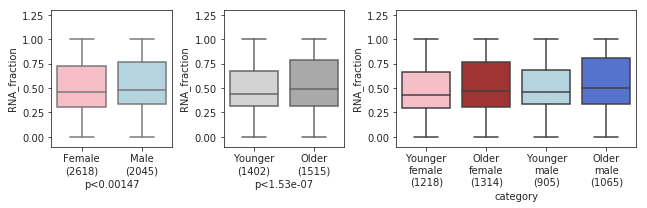

In [7]:
data = data_df.dropna(subset=['gender','age_categorical_3070'])
data['RNA_fraction'] = data['Tumor_Seq_Allele2_readcounts']/(data['Reference_Allele_readcounts']+data['Tumor_Seq_Allele2_readcounts'])
data['category'] = data.apply(lambda x: '{}\n{}'.format(x['age_categorical_3070'], x['gender'].lower()), axis=1)

fig = plt.figure(figsize=(9,3)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[2.5,2.5,5]) 

## Sex
ax0 = plt.subplot(gs[0])
p = mannwhitneyu(data[data['gender']=='FEMALE']['RNA_fraction'].values,
                 data[data['gender']=='MALE']['RNA_fraction'].values).pvalue

sns.boxplot(x='gender', y='RNA_fraction', data=data, order=['FEMALE','MALE'],
            palette=['lightpink', 'lightblue'], ax=ax0)
plt.xlabel('p<{:.3}'.format(p))
plt.ylim(-.1,1.3)
plt.xticks([0,1], ['Female\n({})'.format(len(set(data[data['gender']=='FEMALE'].index))), 
                   'Male\n({})'.format(len(set(data[data['gender']=='MALE'].index)))])
medians = data.groupby(['gender'])['RNA_fraction'].median()
print('\nSex medians:', medians)

## Age
ax1 = plt.subplot(gs[1])
p = mannwhitneyu(data[data['age_categorical_3070']=='younger']['RNA_fraction'].values,
                 data[data['age_categorical_3070']=='older']['RNA_fraction'].values).pvalue

sns.boxplot(x='age_categorical_3070', y='RNA_fraction', data=data, order=['younger','older'],
            palette=['lightgrey', 'darkgrey'], ax=ax1)
plt.xlabel('p<{:.3}'.format(p))
plt.xticks([0,1], ['Younger\n({})'.format(len(set(data[data['age_categorical_3070']=='younger'].index))), 
                   'Older\n({})'.format(len(set(data[data['age_categorical_3070']=='older'].index)))])
plt.ylim(-.1,1.3)
medians = data.groupby(['age_categorical_3070'])['RNA_fraction'].median()
print('\nAge medians:', medians)

## Both
ax2 = plt.subplot(gs[2])
print('\nCombined P-values: ',get_joint_pvals(data, 'RNA_fraction'))


sns.boxplot(x='category', y='RNA_fraction', data=data, palette=['lightpink','firebrick','lightblue','royalblue'], 
            order=['younger\nfemale','older\nfemale','younger\nmale','older\nmale'], ax=ax2)
plt.ylim(-.1,1.3)
plt.xticks([0,1,2,3],['Younger\nfemale\n({})'.format(len(data[data['category']=='younger\nfemale'])), 
                      'Older\nfemale\n({})'.format(len(data[data['category']=='older\nfemale'])), 
                      'Younger\nmale\n({})'.format(len(data[data['category']=='younger\nmale'])), 
                      'Older\nmale\n({})'.format(len(data[data['category']=='older\nmale']))])
medians = data.groupby(['category'])['RNA_fraction'].median()
print('\nCombined medians:', medians)

## save
savepath = '../figures/S7_mut_expression.boxplot.pdf'
plt.tight_layout()
plt.savefig(savepath)
plt.show()